In [1]:
import numpy
import h5py
import time
import os, sys
import random
from collections import OrderedDict
import itertools
import matplotlib.pyplot as plt
import argparse

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
input_file = 'Level5_IC86.2013_genie_numu.014640.100.hdf5'
filename = "10"
save = False
save_folder_name = "CNN_test_files_%s/"%(filename)

In [4]:
### Import Files ###
f = h5py.File(input_file, 'r')
features_DC = f['features_DC'][:]
features_IC = f['features_IC'][:]
labels = f['labels'][:]
f.close()
del f

In [5]:
# ONLY USE ENERGY FOR NOW
labels = labels[:,0]

assert features_DC.shape[0]==features_IC.shape[0], "DC events not equal to IC events"
assert features_DC.shape[0]==labels.shape[0], "DC events not equatl to IC events"

### Split into training and testing set ###
num_train = int(features_DC.shape[0]*0.9) # 90% of data is training data (traininig+validation), 10% is test data
print("training on {} samples, testing on {} samples".format(num_train, features_DC.shape[0]-num_train))

training on 101736 samples, testing on 11305 samples


In [6]:
features_DC_train = features_DC[:num_train]
features_IC_train = features_IC[:num_train]
labels_train = labels[:num_train]

features_DC_test = features_DC[num_train:]
features_IC_test = features_IC[num_train:]
labels_test = labels[num_train:]

### Specify type for training and testing ##
(X_train_DC_raw, X_train_IC_raw, Y_train_raw) = (features_DC_train, features_IC_train, labels_train)
X_train_DC_raw = X_train_DC_raw.astype("float32")
X_train_IC_raw = X_train_IC_raw.astype("float32")
Y_train_raw = Y_train_raw.astype("float32")

(X_test_DC_raw, X_test_IC_raw, Y_test_raw) = (features_DC_test, features_IC_test, labels_test)
X_test_DC_raw = X_test_DC_raw.astype("float32")
X_test_IC_raw = X_test_IC_raw.astype("float32")
Y_test_raw = Y_test_raw.astype("float32")


In [7]:
## ROBUST SCALER BY HAND ## ####
def RobustScaler(a_list,q1,q3):
    return [(x-q1)/(q3-q1) for x in a_list]

def GetQuartiles(a_list):
    mask_zeros = numpy.logical_or(a_list>0,a_list<0)
    data_list_nozero = data_list[mask_zeros]
    q1, q3 = numpy.percentile(data_list_nozero,[25,75])

    return q1, q3

def TransformData(full_data_set):
    q1_array = [0.7749999761581421, 9915.0, 9963.0, 9940.4541015625, 10.824397087097168]
    q3_array = [1.475000023841858, 10533.0, 10703.0, 10608.0, 314.53932189941406]

    for data_index in range(0,full_data_set.shape[3]):

        data_list = full_data_set[:,:,:,data_index].flatten()
        data_rb = RobustScaler(data_list,q1_array[data_index],q3_array[data_index])
        data_rb = numpy.array(data_rb)

        transformed_data_set = numpy.copy(full_data_set)
        transformed_data_set[:,:,:,0] = data_rb.reshape(full_data_set.shape[0],full_data_set.shape[1],full_data_set.shape[2])

    return transformed_data_set


In [8]:
### Transform input features into specified range ###
X_train_DC_full = TransformData(X_train_DC_raw)
X_test_DC_full  = TransformData(X_test_DC_raw)
X_train_IC_full = TransformData(X_train_IC_raw)
X_test_IC_full  = TransformData(X_test_IC_raw)
print("Finished transforming the data using Robust Scaler")

Finished transforming the data using Robust Scaler


In [29]:
# HOW SPLIT?
#X_train_DC, X_val_DC, X_train_IC, X_val_IC, Y_train, Y_val = train_test_split(X_train_DC_selected, X_train_IC_selected, Y_train_full, test_size=0.25)
Y_train_full = numpy.copy(Y_train_raw)
Y_test       = numpy.copy(Y_test_raw)
X_train_DC = numpy.copy(X_train_DC_full)
X_test_DC           = numpy.copy(X_test_DC_full)
X_train_IC = numpy.copy(X_train_IC_full)
X_test_IC           = numpy.copy(X_test_IC_full)
Y_train = numpy.copy(Y_train_full)

# Return features and labels, to be used for network
num_features_DC = X_train_DC.shape[-1]
num_features_IC = X_train_IC.shape[-1]
num_labels = 1 #Y_train.shape[-1] ## NEED TO CHANGE MANUALLY!

In [ ]:
### Build The Network ##

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import initializers
from keras.optimizers import SGD
from keras.optimizers import Adam

## DEEPCORE ##
print("Train Data DC", X_train_DC.shape)
strings = X_train_DC.shape[1]
dom_per_string = X_train_DC.shape[2]
dom_variables = X_train_DC.shape[3]

# Conv DC + batch normalization, later dropout and maxpooling
DC_drop_value = 0.4
input_DC = Input(shape=(strings, dom_per_string, dom_variables))

conv1_DC = Conv2D(100,kernel_size=(strings,5),padding='same',activation='relu')(input_DC)
pool1_DC = MaxPooling2D(pool_size=(1,2))(conv1_DC)
drop1_DC = Dropout(DC_drop_value)(pool1_DC)

conv2_DC = Conv2D(100,kernel_size=(strings,3),padding='valid',activation='relu')(drop1_DC)
pool2_DC = MaxPooling2D(pool_size=(1,2))(conv2_DC)
drop2_DC = Dropout(DC_drop_value)(pool2_DC)

conv3_DC = Conv2D(100,kernel_size=(1,7),padding='same',activation='relu')(drop2_DC)
drop3_DC = Dropout(DC_drop_value)(conv3_DC)

conv4_DC = Conv2D(100,kernel_size=(1,3),padding='same',activation='relu')(drop3_DC)
drop4_DC = Dropout(DC_drop_value)(conv4_DC)

conv5_DC = Conv2D(100,kernel_size=(1,1),padding='same',activation='relu')(drop4_DC)
drop5_DC = Dropout(DC_drop_value)(conv5_DC)

flat_DC = Flatten()(drop5_DC)

# ICECUBE NEAR DEEPCORE #
print("Train Data IC", X_train_IC.shape)
strings_IC = X_train_IC.shape[1]
dom_per_string_IC = X_train_IC.shape[2]
dom_variables_IC = X_train_IC.shape[3]

IC_drop_value = 0.2
input_IC = Input(shape=(strings_IC, dom_per_string_IC, dom_variables_IC))

conv1_IC = Conv2D(100,kernel_size=(strings_IC,5),padding='same',activation='relu')(input_IC)
pool1_IC = MaxPooling2D(pool_size=(1,2))(conv1_IC)
drop1_IC = Dropout(IC_drop_value)(pool1_IC)

conv2_IC = Conv2D(100,kernel_size=(strings_IC,3),padding='valid',activation='relu')(drop1_IC)
pool2_IC = MaxPooling2D(pool_size=(1,2))(conv2_IC)
drop2_IC = Dropout(IC_drop_value)(pool2_IC)

conv3_IC = Conv2D(100,kernel_size=(1,7),padding='same',activation='relu')(drop2_IC)
drop3_IC = Dropout(IC_drop_value)(conv3_IC)

conv4_IC = Conv2D(100,kernel_size=(1,3),padding='same',activation='relu')(drop3_IC)
drop4_IC = Dropout(IC_drop_value)(conv4_IC)

conv5_IC = Conv2D(100,kernel_size=(1,1),padding='same',activation='relu')(drop4_IC)
drop5_IC = Dropout(IC_drop_value)(conv5_IC)

flat_IC = Flatten()(drop5_IC)

# PUT TOGETHER #
connected_drop_value = 0.5
concatted = concatenate([flat_DC, flat_IC])

full1 = Dense(300,activation='relu')(concatted)
dropf = Dropout(connected_drop_value)(full1)

output = Dense(num_labels, activation='linear')(dropf) #kernel_initializer=initializers.RandomUniform(minval=0., maxval=60., seed=None)
lambda_layer = Lambda(lambda x: (x*60.)/100.)(output)
model_DC = Model(inputs=[input_DC,input_IC],outputs=lambda_layer)

print(model_DC.summary())

In [31]:
## Run neural network and record time ##
t0 = time.time()
model_DC.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.0001),
              metrics=['mean_squared_error'])


In [32]:
network_history = model_DC.fit([X_train_DC, X_train_IC], Y_train,
                            batch_size=256,
                            validation_split=0.25,
                            epochs=20,
                            verbose=1)

t1 = time.time()
print("This took me %f minutes"%((t1-t0)/60.))

Train on 76302 samples, validate on 25434 samples
Epoch 1/20
76302/76302 [==============================] - 88s 1ms/step - loss: 296.9125 - mean_squared_error: 296.9125 - val_loss: 210.8552 - val_mean_squared_error: 210.8552
Epoch 2/20
76302/76302 [==============================] - 87s 1ms/step - loss: 99.5417 - mean_squared_error: 99.5417 - val_loss: 159.2595 - val_mean_squared_error: 159.2595
Epoch 3/20
76302/76302 [==============================] - 88s 1ms/step - loss: 84.6995 - mean_squared_error: 84.6995 - val_loss: 170.2893 - val_mean_squared_error: 170.2893
Epoch 4/20
76302/76302 [==============================] - 87s 1ms/step - loss: 77.5036 - mean_squared_error: 77.5036 - val_loss: 185.2190 - val_mean_squared_error: 185.2190
Epoch 5/20
76302/76302 [==============================] - 87s 1ms/step - loss: 74.2869 - mean_squared_error: 74.2869 - val_loss: 195.2723 - val_mean_squared_error: 195.2723
Epoch 6/20
76302/76302 [==============================] - 87s 1ms/step - loss: 72.3

In [33]:
score = model_DC.evaluate([X_test_DC,X_test_IC], Y_test, batch_size=256)
print("final score on test data: loss: {:.4f} / accuracy: {:.4f}".format(score[0], score[1]))
print(network_history.history.keys())
print(score)

11305/11305 [==============================] - 4s 320us/step
final score on test data: loss: 207.2784 / accuracy: 207.2784
dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])
[207.2784099594042, 207.27840805897299]


In [34]:
def plot_history(network_history,save=False,savefolder=None):
    """
    Plot history of neural network's loss vs. epoch
    Recieves:
        network_history = array, saved metrics from neural network training
        save = optional, bool to save plot
        savefolder = optional, output folder to save to, if not in current dir
    Returns:
        one plot, saved to files
    """
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    if save == True:
        plt.savefig("%sloss_vs_epochs.png"%savefolder)

In [35]:
def plot_prediction(Y_test, Y_test_predicted,save=False,savefolder=None):
    """
    Plot testing set prediction vs truth and fractional error
    Recieves:
        Y_test = array, Y_test truth
        Y_test_prediction = array, neural network prediction output
        save = optional, bool to save plot
        savefolder = optional, output folder to save to, if not in current dir
    Returns:
        two plots, saved to files
    """
    plt.figure()
    cts,xbin,ybin,img = plt.hist2d(Y_test, Y_test_predicted, bins=60,)
    plt.plot([0,60],[0,60],'k:')
    plt.xlim(0,60)
    plt.ylim(0,60)
    plt.xlabel("True Energy")
    plt.ylabel("NN Predicted Energy")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('counts', rotation=90)
    plt.set_cmap('viridis_r')
    plt.title("Prediction (from NN) vs Truth for Energy")
    if save == True:
        plt.savefig("%senergy_prediction_truth.png"%savefolder)

    fractional_error = abs(Y_test - Y_test_predicted)/ Y_test
    plt.figure()
    plt.title("Fractional Error vs. Energy")
    plt.hist2d(Y_test, fractional_error,bins=60);
    plt.xlabel("True Energy")
    plt.ylabel("Fractional Error")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('counts', rotation=90)
    if save == True:
        plt.savefig("%sFractionalError.png"%savefolder)


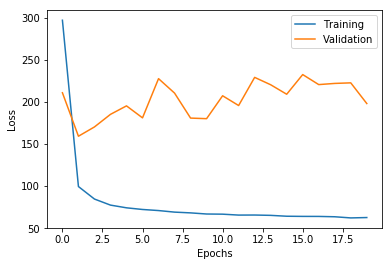

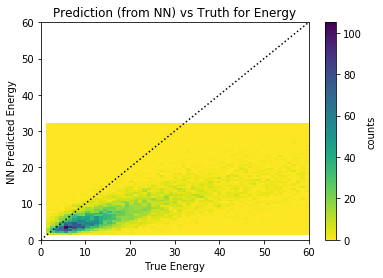

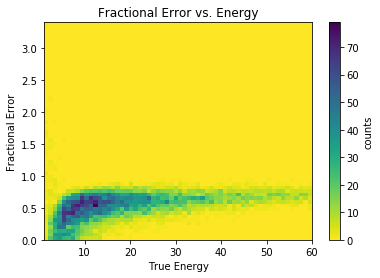

In [36]:
#Use test set to predict values
Y_test_predicted = model_DC.predict([X_test_DC,X_test_IC])

Y_test_predicted = numpy.reshape(Y_test_predicted, Y_test_predicted.shape[0])
Y_test = numpy.reshape(Y_test, Y_test.shape[0])

if save==True:
    if os.path.isdir(save_folder_name) != True:
        os.mkdir(save_folder_name)
    file = open("%soutput.txt"%save_folder_name,"w")
    file.write("training on {} samples, testing on {} samples".format(num_train, len(features)-num_train))
    file.write("final score on test data: loss: {:.4f} / accuracy: {:.4f}\n".format(score[0], score[1]))
    file.write("This took %f minutes"%((t1-t0)/60.))
    file.close()

plot_history(network_history,save,save_folder_name)
plot_prediction(Y_test, Y_test_predicted,save,save_folder_name)

(array([  28.,   78.,  155.,  266.,  329.,  370.,  423.,  470.,  442.,
         423.,  458.,  406.,  385.,  370.,  362.,  381.,  348.,  333.,
         299.,  282.,  266.,  253.,  246.,  236.,  219.,  215.,  171.,
         163.,  193.,  145.,  152.,  157.,  143.,  131.,  127.,  139.,
         122.,  115.,   84.,  103.,  104.,   82.,   76.,   82.,   78.,
          56.,   74.,   60.,   58.,   59.,   43.,   58.,   40.,   42.,
          36.,   35.,   26.,   24.,   38.,   22.,   23.,   17.,   26.,
          14.,   20.,   11.,   14.,   11.,   13.,    3.,    7.,   10.,
           6.,   11.,    2.,    7.,    5.,    5.,    1.,    1.,    2.,
           1.,    3.,    2.,    0.,    0.,    4.,    1.,    0.,    1.,
           0.,    1.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,    1.]),
 array([  1.26486874,   1.57153512,   1.8782015 ,   2.18486789,
          2.49153427,   2.79820065,   3.10486704,   3.41153342,
          3.71819981,   4.02486619,   4.33153257,   4.63819896,
          4.944865

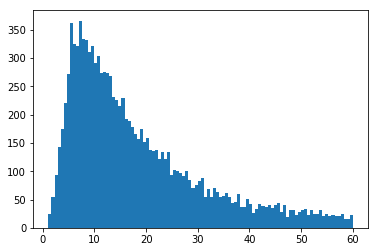

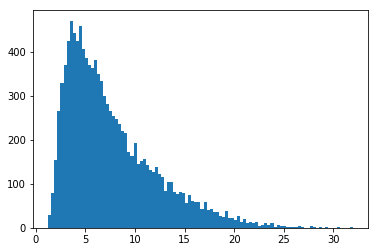

In [37]:
plt.hist(Y_test, bins=100)

plt.figure()
plt.hist(Y_test_predicted, bins=100)

In [ ]:
print(Y_test_predicted)